In [52]:
import os 
import re
import keras
import spacy 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

#Based on example here: https://devklaus.wordpress.com/2018/03/11/sentiment-analysis-on-us-twitter-airlines-dataset-a-deep-learning-approach/

In [53]:
train = pd.read_csv('../data/train.csv',sep=';',index_col=0)
val = pd.read_csv('../data/val.csv',sep=';',index_col=0)
test = pd.read_csv('../data/test.csv',sep=';',index_col=0)

In [54]:
df = train.append(val).append(test)

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].values)
freq = pd.DataFrame([[tok, tokenizer.word_counts[tok]] for tok in tokenizer.word_counts],columns=['token','frequency'])
freq = freq.sort_values('frequency',ascending=False)

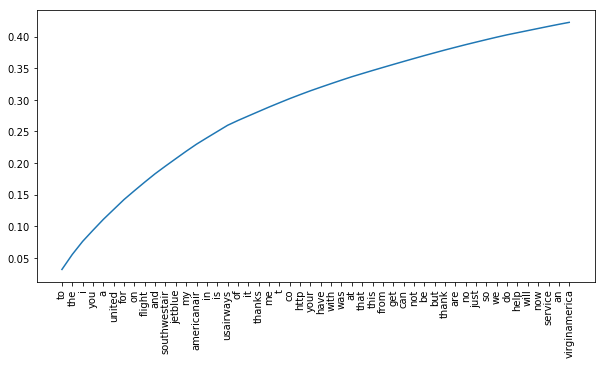

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
tmp = freq[freq['frequency']> 1].iloc[:50].set_index('token')
tmp['frequency'].values,tmp.index.values
x = np.arange(len(tmp.index))
plt.figure(figsize=(10,5))
plt.plot(x,tmp.frequency.values.cumsum()/freq['frequency'].sum())
plt.xticks(x, tmp.index.values,rotation=90);

In [59]:
def get_embeddings(vocab):
    max_rank = max(lex.rank for lex in vocab if lex.has_vector)
    vectors = numpy.ndarray((max_rank+1, vocab.vectors_length), dtype='float32')
    for lex in vocab:
        if lex.has_vector:
            vectors[lex.rank] = lex.vector
    return vectors
  
nlp = spacy.load('en_core_web_md', parser=False, tagger=False, entity=False)
#embeddings = get_embeddings(nlp.vocab)

In [69]:
type(a.doc)

spacy.tokens.doc.Doc

In [63]:
a = nlp('This is my tweet')
a.

array([-2.96597499e-02,  4.35637474e-01, -1.30057424e-01,  2.84117520e-01,
       -3.65799963e-02, -2.41632480e-02,  3.73749807e-03, -3.71322513e-01,
       -4.40390036e-02,  2.11085010e+00, -3.56056184e-01,  4.50950116e-03,
        6.92687482e-02, -7.42383003e-02, -2.22717240e-01,  1.01709880e-01,
       -2.27713764e-01,  8.79172444e-01, -3.50722522e-02, -1.64292455e-02,
       -1.01740502e-01,  7.28560090e-02,  8.70749727e-03,  4.29335758e-02,
        7.01475069e-02,  1.59788013e-01, -1.73002005e-01, -1.64387487e-02,
       -7.74964988e-02,  3.02484967e-02,  4.75664996e-02,  3.85884255e-01,
        9.87424515e-03,  2.26332508e-02, -2.35744998e-01,  9.90923345e-02,
       -6.05641231e-02, -2.25162506e-01, -1.16804086e-01, -2.66767502e-01,
       -1.55890003e-01,  1.25493988e-01,  5.96125051e-02,  5.14120013e-02,
        4.66250256e-03,  2.23567247e-01, -3.15208495e-01,  1.20882757e-01,
       -7.75662512e-02, -8.76557454e-02, -1.90288261e-01,  1.03678249e-01,
       -1.70940250e-01, -

In [58]:

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train['text'].values.tolist() + val['text'].values.tolist() + test['text'].values.tolist())


X = tokenizer.texts_to_sequences(train['text'].values.tolist() + val['text'].values.tolist() + test['text'].values.tolist())
X = pad_sequences(X)
Xtrain = X[:len(train)]
Xval = X[len(train):len(train)+len(val)]
Xtest = X[len(train)+len(val):]

In [55]:
(train['text'].values.tolist() + val['text'].values.tolist() + test['text'].values.tolist())

"@SouthwestAir you're my early frontrunner for best airline! #oscars2016"

In [59]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = Xtrain.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 33, 128)           256000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
ytrain = pd.get_dummies(train['sentiment']).values
yval = pd.get_dummies(val['sentiment']).values
ytest = pd.get_dummies(test['sentiment']).values
print(Xtrain.shape,ytrain.shape)
print(Xval.shape,yval.shape)
print(Xtest.shape,ytest.shape)

(10000, 33) (10000, 3)
(2000, 33) (2000, 3)
(2640, 33) (2640, 3)


In [62]:
batch_size = 512
history = model.fit(Xtrain, ytrain, epochs = 10, batch_size=batch_size, validation_data=(Xval, yval))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3375 - acc: 0.8700 - val_loss: 0.5758 - val_acc: 0.7855
Epoch 2/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3274 - acc: 0.8699 - val_loss: 0.6019 - val_acc: 0.7855
Epoch 3/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3189 - acc: 0.8760 - val_loss: 0.6187 - val_acc: 0.7875
Epoch 4/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3128 - acc: 0.8778 - val_loss: 0.6223 - val_acc: 0.7820
Epoch 5/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.2994 - acc: 0.8844 - val_loss: 0.6364 - val_acc: 0.7785
Epoch 6/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.2926 - acc: 0.8831 - val_loss: 0.6303 - val_acc: 0.7795
Epoch 7/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.2868 - acc: 0.8906 - val_loss: 0.6365 - val_acc:

In [23]:
Xtrain

array([], shape=(10000, 0), dtype=int32)